## Parameters

In [73]:
import torch.nn as nn

record_number = 223
network_structure = [2, 7, 5, 4]
n_epochs = 45
batch_size = 2
act1 = nn.ReLU()
act2 = nn.Sigmoid()
filename = f'{act1}-{act2}-{network_structure}--{batch_size}{record_number}.png'

## Importing Data

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("kaggle.csv")
print(df["record"].unique())
df = df[df['record'] == record_number]

[101 106 108 109 112 114 115 116 118 119 122 124 201 203 205 207 208 209
 215 220 223 230 100 103 105 111 113 117 121 123 200 202 210 212 213 214
 219 221 222 228 231 232 233 234]


In [75]:
df = df[["record", "type", "0_qrs_interval", "0_pre-RR", "0_post-RR"]]
df["0_rr_interval"] = df["0_post-RR"]
df.dropna(inplace=True)

<Axes: >

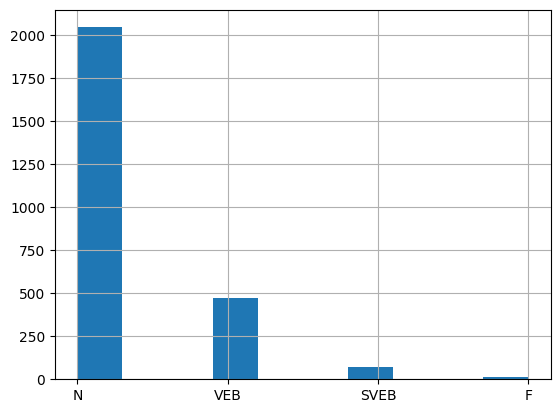

In [76]:
df['type'].hist()

## Making outputs

In [77]:
df['type'] = df["type"].map({
    "N": [1, 0, 0, 0],
    "SVEB": [ 0, 1, 0, 0],
    "VEB": [0, 0, 1, 0],
    "F": [0, 0, 0, 1]
})

## Making x, y

In [78]:
X = df[["0_pre-RR" ,"0_qrs_interval"]]
y = np.array(df["type"].tolist())

In [79]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X, y = sm.fit_resample(X=X, y=y)

In [80]:
X = (X - X.mean()) / X.std()

## Splitting data for training and testing

In [81]:
from sklearn.model_selection import train_test_split
import torch

X = torch.from_numpy(X.values).float()
y = torch.from_numpy(y).float()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1
)

## Arrhythmia Classifier

In [82]:
class Arrhythmia_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(network_structure[0], network_structure[1])
        self.act1 = act1
        self.hidden2 = nn.Linear(network_structure[1],network_structure[2])
        self.act2 = act2
        self.output = nn.Linear(network_structure[2], network_structure[3])

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x


model = Arrhythmia_classifier()
model

Arrhythmia_classifier(
  (hidden1): Linear(in_features=2, out_features=7, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=7, out_features=5, bias=True)
  (act2): Sigmoid()
  (output): Linear(in_features=5, out_features=4, bias=True)
)

In [83]:
import torch.optim as optim
import numpy as np
import random

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
random.seed(10)

In [84]:
import tqdm
import copy


batches_per_epoch = len(X_train) // batch_size

best_acc = -np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")

model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 2861/2861 [00:06<00:00, 434.65batch/s, acc=0, loss=1.38]   


Epoch 0 validation: Cross-entropy=0.6995819211006165, Accuracy=0.7089278697967529


Epoch 1: 100%|██████████| 2861/2861 [00:08<00:00, 344.45batch/s, acc=0, loss=1.56]   


Epoch 1 validation: Cross-entropy=0.6359966993331909, Accuracy=0.7329800128936768


Epoch 2: 100%|██████████| 2861/2861 [00:08<00:00, 347.23batch/s, acc=0, loss=1.34]   


Epoch 2 validation: Cross-entropy=0.6203511357307434, Accuracy=0.7476559281349182


Epoch 3: 100%|██████████| 2861/2861 [00:07<00:00, 363.54batch/s, acc=0, loss=1.33]   


Epoch 3 validation: Cross-entropy=0.6075202226638794, Accuracy=0.7448022961616516


Epoch 4: 100%|██████████| 2861/2861 [00:08<00:00, 354.62batch/s, acc=0, loss=1.21]   


Epoch 4 validation: Cross-entropy=0.6007974147796631, Accuracy=0.736241340637207


Epoch 5: 100%|██████████| 2861/2861 [00:08<00:00, 347.73batch/s, acc=0, loss=1.19]   


Epoch 5 validation: Cross-entropy=0.5913324952125549, Accuracy=0.7370566725730896


Epoch 6: 100%|██████████| 2861/2861 [00:08<00:00, 318.62batch/s, acc=0, loss=1.31]   


Epoch 6 validation: Cross-entropy=0.57832932472229, Accuracy=0.7386873364448547


Epoch 7: 100%|██████████| 2861/2861 [00:10<00:00, 280.02batch/s, acc=0, loss=1.36]   


Epoch 7 validation: Cross-entropy=0.5728444457054138, Accuracy=0.7427639365196228


Epoch 8: 100%|██████████| 2861/2861 [00:08<00:00, 325.54batch/s, acc=0, loss=1.38]   


Epoch 8 validation: Cross-entropy=0.5723507404327393, Accuracy=0.7427639365196228


Epoch 9: 100%|██████████| 2861/2861 [00:09<00:00, 308.15batch/s, acc=0, loss=1.46]   


Epoch 9 validation: Cross-entropy=0.5730675458908081, Accuracy=0.7395026683807373


Epoch 10: 100%|██████████| 2861/2861 [00:09<00:00, 297.51batch/s, acc=0, loss=1.33]   


Epoch 10 validation: Cross-entropy=0.5703016519546509, Accuracy=0.7431716322898865


Epoch 11: 100%|██████████| 2861/2861 [00:08<00:00, 338.92batch/s, acc=0, loss=1.29]   


Epoch 11 validation: Cross-entropy=0.566584587097168, Accuracy=0.7492865920066833


Epoch 12: 100%|██████████| 2861/2861 [00:09<00:00, 306.96batch/s, acc=0, loss=1.61]   


Epoch 12 validation: Cross-entropy=0.5517877340316772, Accuracy=0.7627394795417786


Epoch 13: 100%|██████████| 2861/2861 [00:10<00:00, 279.73batch/s, acc=0, loss=1.66]   


Epoch 13 validation: Cross-entropy=0.5517423152923584, Accuracy=0.7594782114028931


Epoch 14: 100%|██████████| 2861/2861 [00:08<00:00, 357.19batch/s, acc=0, loss=1.66]   


Epoch 14 validation: Cross-entropy=0.5420386791229248, Accuracy=0.7558091878890991


Epoch 15: 100%|██████████| 2861/2861 [00:08<00:00, 324.10batch/s, acc=0, loss=1.61]   


Epoch 15 validation: Cross-entropy=0.5342740416526794, Accuracy=0.7492865920066833


Epoch 16: 100%|██████████| 2861/2861 [00:09<00:00, 308.13batch/s, acc=0, loss=1.63]   


Epoch 16 validation: Cross-entropy=0.5261813402175903, Accuracy=0.7529555559158325


Epoch 17: 100%|██████████| 2861/2861 [00:08<00:00, 335.98batch/s, acc=0, loss=1.63]   


Epoch 17 validation: Cross-entropy=0.5134624242782593, Accuracy=0.75214022397995


Epoch 18: 100%|██████████| 2861/2861 [00:08<00:00, 339.19batch/s, acc=0, loss=1.6]    


Epoch 18 validation: Cross-entropy=0.5107867121696472, Accuracy=0.7533632516860962


Epoch 19: 100%|██████████| 2861/2861 [00:08<00:00, 339.08batch/s, acc=0, loss=1.59]   


Epoch 19 validation: Cross-entropy=0.5105497241020203, Accuracy=0.7541785836219788


Epoch 20: 100%|██████████| 2861/2861 [00:08<00:00, 338.66batch/s, acc=0, loss=1.59]   


Epoch 20 validation: Cross-entropy=0.5066549777984619, Accuracy=0.7513248920440674


Epoch 21: 100%|██████████| 2861/2861 [00:08<00:00, 328.88batch/s, acc=0, loss=1.59]   


Epoch 21 validation: Cross-entropy=0.5043989419937134, Accuracy=0.7545862197875977


Epoch 22: 100%|██████████| 2861/2861 [00:08<00:00, 330.85batch/s, acc=0, loss=1.57]   


Epoch 22 validation: Cross-entropy=0.5050083994865417, Accuracy=0.7554015517234802


Epoch 23: 100%|██████████| 2861/2861 [00:08<00:00, 343.34batch/s, acc=0, loss=1.51]   


Epoch 23 validation: Cross-entropy=0.5103542804718018, Accuracy=0.7574398517608643


Epoch 24: 100%|██████████| 2861/2861 [00:08<00:00, 341.23batch/s, acc=0, loss=1.51]   


Epoch 24 validation: Cross-entropy=0.507491409778595, Accuracy=0.7586628794670105


Epoch 25: 100%|██████████| 2861/2861 [00:08<00:00, 346.57batch/s, acc=0, loss=1.47]   


Epoch 25 validation: Cross-entropy=0.5129157900810242, Accuracy=0.7492865920066833


Epoch 26: 100%|██████████| 2861/2861 [00:08<00:00, 347.51batch/s, acc=0, loss=1.57]   


Epoch 26 validation: Cross-entropy=0.510424792766571, Accuracy=0.7525479197502136


Epoch 27: 100%|██████████| 2861/2861 [00:08<00:00, 337.90batch/s, acc=0, loss=1.56]   


Epoch 27 validation: Cross-entropy=0.5158628821372986, Accuracy=0.7501019239425659


Epoch 28: 100%|██████████| 2861/2861 [00:08<00:00, 330.29batch/s, acc=0, loss=1.56]   


Epoch 28 validation: Cross-entropy=0.5090541243553162, Accuracy=0.7505095601081848


Epoch 29: 100%|██████████| 2861/2861 [00:08<00:00, 342.04batch/s, acc=0, loss=1.57]   


Epoch 29 validation: Cross-entropy=0.5075992941856384, Accuracy=0.7496942281723022


Epoch 30: 100%|██████████| 2861/2861 [00:08<00:00, 345.09batch/s, acc=0, loss=1.5]    


Epoch 30 validation: Cross-entropy=0.5145922303199768, Accuracy=0.7480636239051819


Epoch 31: 100%|██████████| 2861/2861 [00:08<00:00, 340.24batch/s, acc=0, loss=1.52]   


Epoch 31 validation: Cross-entropy=0.5071420073509216, Accuracy=0.7513248920440674


Epoch 32: 100%|██████████| 2861/2861 [00:08<00:00, 347.14batch/s, acc=0, loss=1.36]   


Epoch 32 validation: Cross-entropy=0.5093958973884583, Accuracy=0.7484712600708008


Epoch 33: 100%|██████████| 2861/2861 [00:08<00:00, 338.22batch/s, acc=0, loss=1.36]   


Epoch 33 validation: Cross-entropy=0.5284200310707092, Accuracy=0.7496942281723022


Epoch 34: 100%|██████████| 2861/2861 [00:08<00:00, 345.54batch/s, acc=0, loss=1.55]   


Epoch 34 validation: Cross-entropy=0.5174993872642517, Accuracy=0.7501019239425659


Epoch 35: 100%|██████████| 2861/2861 [00:08<00:00, 343.12batch/s, acc=0, loss=1.44]   


Epoch 35 validation: Cross-entropy=0.5131289958953857, Accuracy=0.7505095601081848


Epoch 36: 100%|██████████| 2861/2861 [00:08<00:00, 332.21batch/s, acc=0, loss=1.51]   


Epoch 36 validation: Cross-entropy=0.5088214874267578, Accuracy=0.7488788962364197


Epoch 37: 100%|██████████| 2861/2861 [00:08<00:00, 343.31batch/s, acc=0, loss=1.49]   


Epoch 37 validation: Cross-entropy=0.5080505609512329, Accuracy=0.7492865920066833


Epoch 38: 100%|██████████| 2861/2861 [00:08<00:00, 339.67batch/s, acc=0, loss=1.47]   


Epoch 38 validation: Cross-entropy=0.5082418918609619, Accuracy=0.7480636239051819


Epoch 39: 100%|██████████| 2861/2861 [00:08<00:00, 346.00batch/s, acc=0, loss=1.51]   


Epoch 39 validation: Cross-entropy=0.5162036418914795, Accuracy=0.7480636239051819


Epoch 40: 100%|██████████| 2861/2861 [00:09<00:00, 317.66batch/s, acc=0, loss=1.43]   


Epoch 40 validation: Cross-entropy=0.507361114025116, Accuracy=0.7513248920440674


Epoch 41: 100%|██████████| 2861/2861 [00:10<00:00, 285.50batch/s, acc=0, loss=1.46]   


Epoch 41 validation: Cross-entropy=0.515834391117096, Accuracy=0.7505095601081848


Epoch 42: 100%|██████████| 2861/2861 [00:08<00:00, 326.24batch/s, acc=0, loss=1.46]   


Epoch 42 validation: Cross-entropy=0.5282191038131714, Accuracy=0.7468405961990356


Epoch 43: 100%|██████████| 2861/2861 [00:08<00:00, 343.48batch/s, acc=0, loss=1.46]   


Epoch 43 validation: Cross-entropy=0.505862832069397, Accuracy=0.7472482919692993


Epoch 44: 100%|██████████| 2861/2861 [00:08<00:00, 329.46batch/s, acc=0, loss=1.5]    


Epoch 44 validation: Cross-entropy=0.5060880780220032, Accuracy=0.7496942281723022


<All keys matched successfully>

In [85]:
model.state_dict()

OrderedDict([('hidden1.weight',
              tensor([[ 1.3007, -4.3365],
                      [-3.2842,  2.1436],
                      [ 1.4560,  0.6779],
                      [ 0.0320,  1.3538],
                      [-1.7310, -2.3730],
                      [ 1.4431,  4.1241],
                      [ 3.7681,  2.1180]])),
             ('hidden1.bias',
              tensor([-0.8926,  0.4598, -0.5777,  0.3020, -1.0205, -1.3819, -0.3864])),
             ('hidden2.weight',
              tensor([[-6.0513,  0.2992,  1.4625,  0.4259,  0.3914, -5.9317,  3.3772],
                      [ 1.2643,  9.3866, -0.1497, -1.0325, -0.5696,  1.3023, -0.6901],
                      [-0.4703, -0.8287, -0.6070,  0.5195, -1.0538,  0.0676, -0.9468],
                      [ 2.0593, -3.4069,  0.8255, -0.0228, -7.2963,  5.4095,  2.0794],
                      [-2.2661,  2.5600, -0.7474,  1.4239, -2.1599,  0.9613, -1.4848]])),
             ('hidden2.bias',
              tensor([-1.2752, -6.6612,  5.7833, -3.2

## Plotting Cross entropy and accuracy

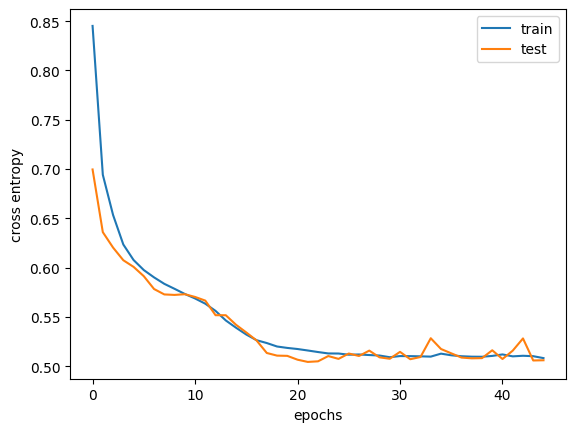

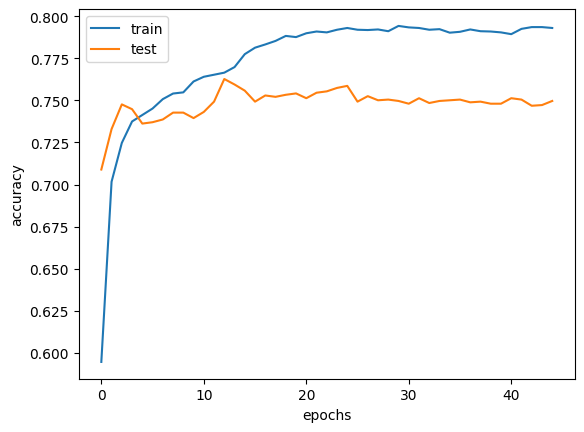

In [86]:
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.savefig(filename)
plt.show()